In [1]:
import illustris_python as il
import numpy as np

import h5py

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.offsetbox import AnchoredText

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy import units as u

from scipy.ndimage.filters import uniform_filter, gaussian_filter


import os

import pickle

In [2]:
basePath = './sims.TNG/TNG300-1/output/'

In [3]:
snaps_full = np.array([99, 91, 84, 78, 72, 67, 63, 59, 56, 53, 50, 40, 33])
zs_full = np.array([0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00, 1.50, 2.00])

In [4]:
SFRs = h5py.File('star_formation_rates.hdf5', 'r')

In [5]:
groups = il.groupcat.loadHalos(basePath, 99, fields=['GroupFirstSub', 'GroupNsubs','Group_M_Crit200', 'Group_R_Crit200', 'GroupPos'])

In [6]:
Mcrit200 = groups['Group_M_Crit200'] * 1e10 / 0.704

In [7]:
candidates = np.where(Mcrit200 >= 10**14)[0] #group id at z = 0
print(f'total {len(candidates)} galaxy clusters found in IllustrisTNG300')

total 266 galaxy clusters found in IllustrisTNG300


In [8]:
sub_first = groups['GroupFirstSub'][candidates]

In [9]:
fields = ['SubfindID', 'SnapNum', 'SubhaloGrNr', 'SubhaloMassInRad', 'SubhaloPos']

trees = []

for idx in sub_first:
    
    tree = il.sublink.loadTree(basePath, 99, idx, fields=fields, onlyMPB = True)
    trees.append(tree)
    

In [10]:
trees = np.array(trees)

In [11]:
counts = [x['count'] for x in trees]
counts = np.array(counts)

In [12]:
track_mask = (counts >= 50)

In [13]:
candidates = candidates[track_mask]
trees = trees[track_mask]

In [14]:
len(candidates), len(trees)

(264, 264)

In [15]:
# candidTes

# Track accreting subhalos - save files for analysis

- subhalos for $M_{\odot} \leq 10^{13}$

- groups for $M_{\odot} \geq 10^{13}$

In [16]:
def cal_fof(start, cands):
    
    check = np.full(len(cands), True, dtype = bool)
    
    f1mask = np.sqrt(np.sum((cands - start)**2, axis = 1)) <= 4
    f1_index = list(np.where(f1mask)[0])
    
    check[f1mask] = False
    
    if len(f1_index) == 0:
        return []
    
    new_index = []
    
    temp_index = []
    
    first = True
    
    while True:
        if first:
            first = False
            cand_index = f1_index.copy()
        else:
            cand_index = temp_index.copy()
            temp_index = []
            
        for j in range(len(cand_index)):
            f2mask = np.sqrt(np.sum((cands - cands[cand_index[j]])**2, axis = 1)) <= 4
            f2_index = np.where(f2mask & check)[0]
            
            check[f2_index] = False
            
            if len(f2_index) == 0:
                continue
            
            temp_index.extend(list(f2_index))
            
        new_index.extend(temp_index)
        
        if len(temp_index) ==0:
            break
    
    f1_index.extend(new_index)
    final_index = f1_index
    
    return final_index

In [ ]:
## stellar mass cut 9.5

for isnap, snap in enumerate(snaps_full):
    
    print(snap, end = ' ')
    
#     if snap in [99, 91, 84, 78, 72, 67, 63, 59, 56, 53, 50, 40]:
#         continue
    
#     halos = h5py.File(f'halo_structure_{snap:03d}.hdf5')
    
    # load subhalo at given snap
    subhalos_curr = h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r')
    z = zs_full[snaps_full == snap][0]
    
    # galaxy mask
    gal_mask = subhalos_curr['SubhaloMassType'][:, 4] * 1e10 / 0.704 >= 10**8.5
    
    #grid at certain snap
    bins = np.arange(0 , 205000, 500)
    coords = np.array(list(zip(subhalos_curr['SubhaloPos'][:, 0][gal_mask], subhalos_curr['SubhaloPos'][:, 1][gal_mask], subhalos_curr['SubhaloPos'][:, 2][gal_mask])))
    
    grid, (xedges, yedges, zedges) = np.histogramdd(coords, bins = (bins, bins, bins))
    mean, std = np.mean(grid), np.std(grid)
    
    filtered = uniform_filter(grid, 3, mode = 'wrap')
    mean2, std2 = np.mean(filtered), np.std(filtered)    
    
    
    # investigate the individual galaxy cluster candidates at given snapshot
#     con_cluster = []z
    fq_cluster = []
    fof_cluster = []
    
    fq_infall_sub = []
    n_infall_sub = []
    
    fq_infall_grp = []
    n_infall_grp = []
    
    for c in range(len(trees)):
    
        t = trees[c]
        
        curr_mask = t['SnapNum'] == snap
        
        if sum(curr_mask) == 0:
#             con_cluster.append(np.nan)
            fq_cluster.append(np.nan)
            fof_cluster.append(np.nan)
            
            fq_infall_sub.append(np.nan)
            fq_infall_grp.append(np.nan)
            
            n_infall_sub.append(np.nan)
            n_infall_grp.append(np.nan)
            continue
        
        # current member
        grnr_snap = t['SubhaloGrNr'][curr_mask][0]
        
        mem_mask = subhalos_curr['SubhaloGrNr'][:] == grnr_snap
        ids_currmem = np.where(mem_mask & gal_mask)[0]
        
        if len(ids_currmem) == 0:
            fq_cluster.append(np.nan)
            fof_cluster.append(np.nan)
            
            fq_infall_sub.append(np.nan)
            fq_infall_grp.append(np.nan)
            
            n_infall_sub.append(np.nan)
            n_infall_grp.append(np.nan)
            continue
            
        # calculate FoF
        with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
            center_pos = f['GroupPos'][:][grnr_snap]
        
        if (center_pos[0] <= 10000) | (center_pos[0] >= (205000 - 10000)) | (center_pos[1] <= 10000 ) | (center_pos[1] >= (205000 - 10000) ) | (center_pos[2] <= 10000 ) | (center_pos[2] >= (205000 - 10000) ):
#             con_cluster.append(np.nan)
            fq_cluster.append(np.nan)
            fof_cluster.append(np.nan)
            
            fq_infall_sub.append(np.nan)
            fq_infall_grp.append(np.nan)
            
            n_infall_sub.append(np.nan)
            n_infall_grp.append(np.nan)
            continue

        
        xidx, yidx, zidx = [int(center_pos[i]/500) for i in range(3)]
        subgrid = grid[xidx-20:xidx+20, yidx-20:yidx+20, zidx-20:zidx+20]

        start = np.array([20, 20, 20])
        cands = np.argwhere(subgrid > mean2 + 2 * std2)

        findex = cal_fof(start, cands)
        fof = len(findex) / 40**3
        
        fof_cluster.append(fof)
        
        # calculate concentration
#         if snap in [63, 56, 59, 63]:
#             con_cluster.append(np.nan)
#         else:
#             con_cluster.append(halos['c200c'][grnr_snap])
        
    
        ##### QF in galaxy cluster
        sfr_mask = [np.where(SFRs[f'Snapshot_{snap}']['SubfindID'][:] == x)[0][0] for x in ids_currmem]# np.isin(SFRs[f'Snapshot_{snap}']['SubfindID'][:], ids_currmem) # SFR file
#         sfr_mask = np.array(sfr_mask)
        quies_mask = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_100Myrs'][sfr_mask] / (subhalos_curr['SubhaloMassInRad'][:][ids_currmem] * 1e10 / 0.704) <= 1 / 3 / cosmo.age(z).to(u.yr).value

        fq_cl = sum(quies_mask) / len(ids_currmem)
        fq_cluster.append(fq_cl)
    
    
        ##### QF in infalling groups and subhalos
        before_mask = t['SnapNum'] == snap - 1
        
        if sum(before_mask) == 0:
            fq_infall_sub.append(np.nan)
            fq_infall_grp.append(np.nan)
            
            n_infall_sub.append(np.nan)
            n_infall_grp.append(np.nan)
            continue
        
        # infalling member
        grnr_snap_before = t['SubhaloGrNr'][before_mask][0]
        
        # find infalling candidates
        cands_grnr = subhalos_curr['SubhaloGrNr'][:]
            
        cands_idxs = np.where((cands_grnr == grnr_snap) & gal_mask)[0]
        
        cands_tree = []
        fields = ['SubfindID', 'SnapNum', 'SubhaloGrNr']
        for idx in cands_idxs:
            
            try:
                tree = il.sublink.loadTree(basePath, snap, idx, fields=fields, onlyMPB = True)
            except:
                pass
            
            if tree: #if not none
                cands_tree.append(tree)
                
        cands_tree = [x for x in cands_tree if  np.any(x['SnapNum'] == snap) & np.any(x['SnapNum'] == snap-1)]
        cands_tree = [x for x in cands_tree if (x['SubhaloGrNr'][x['SnapNum'] == snap][0] == grnr_snap) & (x['SubhaloGrNr'][x['SnapNum'] == snap-1][0] != grnr_snap_before)]
        cands_tree = np.array(cands_tree)
        
        ids_infallmem = np.array([x['SubfindID'][x['SnapNum'] == snap-1][0] for x in cands_tree])
        
        # when there is no infalling group/subhalo 
        if len(ids_infallmem) == 0:
            fq_infall_sub.append(np.nan)
            fq_infall_grp.append(np.nan)
            
            n_infall_sub.append(np.nan)
            n_infall_grp.append(np.nan)
            continue
        
        # match infalling members to GrNr
        grnr_infallmem = np.array([x['SubhaloGrNr'][x['SnapNum'] == snap-1][0] for x in cands_tree])
        grnr_infallmem = np.unique(grnr_infallmem)
        
        with h5py.File(f'./groups/grp_snap{snap-1}.hdf5', 'r') as f:
            grp_mass_snap_before = f['Group_M_Crit200'][:] * 1e10 / 0.704
        
        grnr_grp = [g for g in grnr_infallmem if grp_mass_snap_before[g] >= 1e13]
        grnr_sub = [g for g in grnr_infallmem if grp_mass_snap_before[g] < 1e13]
        
        ids_grps = []
        ids_subs = []
        
        if len(grnr_grp) > 0:    
            
            with  h5py.File(f'./subhalos/subs_{snap-1}.hdf5', 'r') as f:        
                ids_grps = [np.where(f['SubhaloGrNr'][:] == i)[0] for i in grnr_grp]
            
                ids_grps = np.concatenate(ids_grps)
                ids_grps = [x for x in ids_grps if f['SubhaloMassInRad'][:][x] * 1e10 / 0.704 >= 10**8.5]
                
                
                sfr_mask_grp = [np.where(SFRs[f'Snapshot_{snap-1}']['SubfindID'][:] == x)[0][0] for x in ids_grps]# np.isin(SFRs[f'Snapshot_{snap-1}']['SubfindID'][:], ids_grps)
#                 sfr_mask_grp = np.array(sfr_mask_grp)
                quies_mask_grp = SFRs[f'Snapshot_{snap-1}']['SFR_MsunPerYrs_in_InRad_100Myrs'][:][sfr_mask_grp] / (f['SubhaloMassInRad'][:][ids_grps] * 1e10 / 0.704) <= 1 / 3 / cosmo.age(z).to(u.yr).value
                
                fq_grp = sum(quies_mask_grp) / len(quies_mask_grp)
                fq_infall_grp.append(fq_grp)
                n_infall_grp.append(len(grnr_grp))
                
        else:
            fq_infall_grp.append(np.nan)
            n_infall_grp.append(np.nan)
            
        
        if len(grnr_sub) > 0:
            with  h5py.File(f'./subhalos/subs_{snap-1}.hdf5', 'r') as f:  
                ids_subs = [np.where(f['SubhaloGrNr'][:] == i)[0] for i in grnr_sub]
            
                ids_subs = np.concatenate(ids_subs)
                ids_subs = [x for x in ids_subs if f['SubhaloMassInRad'][:][x] * 1e10 / 0.704 >= 10**8.5]
                
                sfr_mask_sub = [np.where(SFRs[f'Snapshot_{snap-1}']['SubfindID'][:] == x)[0][0] for x in ids_subs] # np.isin(SFRs[f'Snapshot_{snap-1}']['SubfindID'][:], ids_subs)
#                 sfr_mask_sub = np.array(sfr_mask_sub)
                quies_mask_sub = SFRs[f'Snapshot_{snap-1}']['SFR_MsunPerYrs_in_InRad_100Myrs'][:][sfr_mask_sub] / (f['SubhaloMassInRad'][:][ids_subs] * 1e10 / 0.704) <= 1 / 3 / cosmo.age(z).to(u.yr).value
                
                fq_sub = sum(quies_mask_sub) / len(quies_mask_sub)
                fq_infall_sub.append(fq_sub)
                n_infall_sub.append(len(grnr_sub))
                
        else:
            fq_infall_sub.append(np.nan)
            n_infall_sub.append(np.nan)

#     with open(f'./acchist/con_cluster_snap{snap:d}', 'wb') as f:
#         pickle.dump(con_cluster, f)
        
    with open(f'./acchist_corr_sm8p5/fof_cluster_snap{snap:d}', 'wb') as f:
        pickle.dump(fof_cluster, f)
            
    with open(f'./acchist_corr_sm8p5/fq_cluster_snap{snap:d}', 'wb') as f:
        pickle.dump(fq_cluster, f)
    
    with open(f'./acchist_corr_sm8p5/fq_infall_sub_snap{snap:d}', 'wb') as f:
        pickle.dump(fq_infall_sub, f)
        
    with open(f'./acchist_corr_sm8p5/n_infall_sub_snap{snap:d}', 'wb') as f:
        pickle.dump(n_infall_sub, f)
    
    with open(f'./acchist_corr_sm8p5/fq_infall_grp_snap{snap:d}', 'wb') as f:
        pickle.dump(fq_infall_grp, f)
        
    with open(f'./acchist_corr_sm8p5/n_infall_grp_snap{snap:d}', 'wb') as f:
        pickle.dump(n_infall_grp, f)

In [19]:
ids_currmem

array([], dtype=int64)

In [ ]:
# # fq_clusters = [] ## 99 - 50
# # fq_infall_subs = [] ## 99 - 50
# # n_infall_subs = []
# # fq_infall_grps = []
# # n_infall_grps = []
# # # len_infalls = []

# # snaps_infalls = []
# # snaps_full = np.array([99, 91, 84, 78, 72, 67, 63, 59, 56, 53, 50, 40, 33])

# for isnap, snap in enumerate(snaps_full[7:]):
    
#     print(snap, end = ' ')
        
# #     halos = h5py.File(f'halo_structure_{snap:03d}.hdf5')
    
#     # load subhalo at given snap
#     subhalos_curr = h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r')
#     z = zs_full[snaps_full == snap][0]
    
#     #grid at certain snap
#     bins = np.arange(0 , 205000, 500)
#     coords = np.array(list(zip(subhalos_curr['SubhaloPos'][:, 0], subhalos_curr['SubhaloPos'][:, 1], subhalos_curr['SubhaloPos'][:, 2])))
    
#     grid, (xedges, yedges, zedges) = np.histogramdd(coords, bins = (bins, bins, bins))
#     mean, std = np.mean(grid), np.std(grid)
    
#     filtered = uniform_filter(grid, 3, mode = 'wrap')
#     mean2, std2 = np.mean(filtered), np.std(filtered)    
    
#     # galaxy mask
#     gal_mask = subhalos_curr['SubhaloMassType'][:, 4] * 1e10 / 0.704 >= 10**8.5
    
#     # investigate the individual galaxy cluster candidates at given snapshot
# #     con_cluster = []z
#     fq_cluster = []
#     fof_cluster = []
    
#     fq_infall_sub = []
#     n_infall_sub = []
    
#     fq_infall_grp = []
#     n_infall_grp = []
    
#     for c in range(len(trees)):
    
#         t = trees[c]
        
#         curr_mask = t['SnapNum'] == snap
        
#         if sum(curr_mask) == 0:
# #             con_cluster.append(np.nan)
#             fq_cluster.append(np.nan)
#             fof_cluster.append(np.nan)
            
#             fq_infall_sub.append(np.nan)
#             fq_infall_grp.append(np.nan)
            
#             n_infall_sub.append(np.nan)
#             n_infall_grp.append(np.nan)
#             continue
        
#         # current member
#         grnr_snap = t['SubhaloGrNr'][curr_mask][0]
        
#         mem_mask = subhalos_curr['SubhaloGrNr'][:] == grnr_snap
#         ids_currmem = np.where(mem_mask & gal_mask)[0]
        
#         # calculate FoF
#         with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
#             center_pos = f['GroupPos'][:][grnr_snap]
        
#         if (center_pos[0] <= 10000) | (center_pos[0] >= (205000 - 10000)) | (center_pos[1] <= 10000 ) | (center_pos[1] >= (205000 - 10000) ) | (center_pos[2] <= 10000 ) | (center_pos[2] >= (205000 - 10000) ):
# #             con_cluster.append(np.nan)
#             fq_cluster.append(np.nan)
#             fof_cluster.append(np.nan)
            
#             fq_infall_sub.append(np.nan)
#             fq_infall_grp.append(np.nan)
            
#             n_infall_sub.append(np.nan)
#             n_infall_grp.append(np.nan)
#             continue

        
#         xidx, yidx, zidx = [int(center_pos[i]/500) for i in range(3)]
#         subgrid = grid[xidx-20:xidx+20, yidx-20:yidx+20, zidx-20:zidx+20]

#         start = np.array([20, 20, 20])
#         cands = np.argwhere(subgrid > mean2 + 2 * std2)

#         findex = cal_fof(start, cands)
#         fof = len(findex) / 40**3
        
#         fof_cluster.append(fof)
        
#         # calculate concentration
# #         if snap in [63, 56, 59, 63]:
# #             con_cluster.append(np.nan)
# #         else:
# #             con_cluster.append(halos['c200c'][grnr_snap])
        
    
#         ##### QF in galaxy cluster
#         sfr_mask = [np.where(SFRs[f'Snapshot_{snap}']['SubfindID'][:] == x)[0][0] for x in ids_currmem]# np.isin(SFRs[f'Snapshot_{snap}']['SubfindID'][:], ids_currmem) # SFR file
# #         sfr_mask = np.array(sfr_mask)
#         quies_mask = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_100Myrs'][sfr_mask] / (subhalos_curr['SubhaloMassInRad'][:][ids_currmem] * 1e10 / 0.704) <= 1 / 3 / cosmo.age(z).to(u.yr).value

#         fq_cl = sum(quies_mask) / len(ids_currmem)
#         fq_cluster.append(fq_cl)
    
    
#         ##### QF in infalling groups and subhalos
#         before_mask = t['SnapNum'] == snap - 1
        
#         if sum(before_mask) == 0:
#             fq_infall_sub.append(np.nan)
#             fq_infall_grp.append(np.nan)
            
#             n_infall_sub.append(np.nan)
#             n_infall_grp.append(np.nan)
#             continue
        
#         # infalling member
#         grnr_snap_before = t['SubhaloGrNr'][before_mask][0]
        
#         # find infalling candidates
#         cands_grnr = subhalos_curr['SubhaloGrNr'][:]
            
#         cands_idxs = np.where((cands_grnr == grnr_snap) & gal_mask)[0]
        
#         cands_tree = []
#         fields = ['SubfindID', 'SnapNum', 'SubhaloGrNr']
#         for idx in cands_idxs:
            
#             try:
#                 tree = il.sublink.loadTree(basePath, snap, idx, fields=fields, onlyMPB = True)
#             except:
#                 pass
            
#             if tree: #if not none
#                 cands_tree.append(tree)
                
#         cands_tree = [x for x in cands_tree if  np.any(x['SnapNum'] == snap) & np.any(x['SnapNum'] == snap-1)]
#         cands_tree = [x for x in cands_tree if (x['SubhaloGrNr'][x['SnapNum'] == snap][0] == grnr_snap) & (x['SubhaloGrNr'][x['SnapNum'] == snap-1][0] != grnr_snap_before)]
#         cands_tree = np.array(cands_tree)
        
#         ids_infallmem = np.array([x['SubfindID'][x['SnapNum'] == snap-1][0] for x in cands_tree])
        
#         # when there is no infalling group/subhalo 
#         if len(ids_infallmem) == 0:
#             fq_infall_sub.append(np.nan)
#             fq_infall_grp.append(np.nan)
            
#             n_infall_sub.append(np.nan)
#             n_infall_grp.append(np.nan)
#             continue
        
#         # match infalling members to GrNr
#         grnr_infallmem = np.array([x['SubhaloGrNr'][x['SnapNum'] == snap-1][0] for x in cands_tree])
#         grnr_infallmem = np.unique(grnr_infallmem)
        
#         with h5py.File(f'./groups/grp_snap{snap-1}.hdf5', 'r') as f:
#             grp_mass_snap_before = f['Group_M_Crit200'][:] * 1e10 / 0.704
        
#         grnr_grp = [g for g in grnr_infallmem if grp_mass_snap_before[g] >= 1e13]
#         grnr_sub = [g for g in grnr_infallmem if grp_mass_snap_before[g] < 1e13]
        
#         ids_grps = []
#         ids_subs = []
        
#         if len(grnr_grp) > 0:    
            
#             with  h5py.File(f'./subhalos/subs_{snap-1}.hdf5', 'r') as f:        
#                 ids_grps = [np.where(f['SubhaloGrNr'][:] == i)[0] for i in grnr_grp]
            
#                 ids_grps = np.concatenate(ids_grps)
#                 ids_grps = [x for x in ids_grps if f['SubhaloMassInRad'][:][x] * 1e10 / 0.704 >= 10**8.5]
                
                
#                 sfr_mask_grp = [np.where(SFRs[f'Snapshot_{snap-1}']['SubfindID'][:] == x)[0][0] for x in ids_grps]# np.isin(SFRs[f'Snapshot_{snap-1}']['SubfindID'][:], ids_grps)
# #                 sfr_mask_grp = np.array(sfr_mask_grp)
#                 quies_mask_grp = SFRs[f'Snapshot_{snap-1}']['SFR_MsunPerYrs_in_InRad_100Myrs'][:][sfr_mask_grp] / (f['SubhaloMassInRad'][:][ids_grps] * 1e10 / 0.704) <= 1 / 3 / cosmo.age(z).to(u.yr).value
                
#                 fq_grp = sum(quies_mask_grp) / len(quies_mask_grp)
#                 fq_infall_grp.append(fq_grp)
#                 n_infall_grp.append(len(grnr_grp))
                
#         else:
#             fq_infall_grp.append(np.nan)
#             n_infall_grp.append(np.nan)
            
        
#         if len(grnr_sub) > 0:
#             with  h5py.File(f'./subhalos/subs_{snap-1}.hdf5', 'r') as f: 
#                 ids_subs = [np.where(f['SubhaloGrNr'][:] == i)[0] for i in grnr_sub]
            
#                 ids_subs = np.concatenate(ids_subs)
#                 ids_subs = [x for x in ids_subs if f['SubhaloMassInRad'][:][x] * 1e10 / 0.704 >= 10**8.5]
                
#                 sfr_mask_sub = [np.where(SFRs[f'Snapshot_{snap-1}']['SubfindID'][:] == x)[0][0] for x in ids_subs] # np.isin(SFRs[f'Snapshot_{snap-1}']['SubfindID'][:], ids_subs)
# #                 sfr_mask_sub = np.array(sfr_mask_sub)
#                 quies_mask_sub = SFRs[f'Snapshot_{snap-1}']['SFR_MsunPerYrs_in_InRad_100Myrs'][:][sfr_mask_sub] / (f['SubhaloMassInRad'][:][ids_subs] * 1e10 / 0.704) <= 1 / 3 / cosmo.age(z).to(u.yr).value
                
#                 fq_sub = sum(quies_mask_sub) / len(quies_mask_sub)
#                 fq_infall_sub.append(fq_sub)
#                 n_infall_sub.append(len(grnr_sub))
                
#         else:
#             fq_infall_sub.append(np.nan)
#             n_infall_sub.append(np.nan)

# #     with open(f'./acchist/con_cluster_snap{snap:d}', 'wb') as f:
# #         pickle.dump(con_cluster, f)
        
#     with open(f'./acchist/fof_cluster_snap{snap:d}', 'wb') as f:
#         pickle.dump(fof_cluster, f)
            
#     with open(f'./acchist/fq_cluster_snap{snap:d}', 'wb') as f:
#         pickle.dump(fq_cluster, f)
    
#     with open(f'./acchist/fq_infall_sub_snap{snap:d}', 'wb') as f:
#         pickle.dump(fq_infall_sub, f)
        
#     with open(f'./acchist/n_infall_sub_snap{snap:d}', 'wb') as f:
#         pickle.dump(n_infall_sub, f)
    
#     with open(f'./acchist/fq_infall_grp_snap{snap:d}', 'wb') as f:
#         pickle.dump(fq_infall_grp, f)
        
#     with open(f'./acchist/n_infall_grp_snap{snap:d}', 'wb') as f:
#         pickle.dump(n_infall_grp, f)
    
# #     fq_clusters.append(fq_cluster)
    
# #     fq_infall_subs.append(fq_infall_sub)
# #     n_infall_subs.append(n_infall_sub)
# #     fq_infall_grps.append(fq_infall_grp)
# #     n_infall_grps.append(n_infall_grp)

calculate FOF fraction

In [69]:
def cal_fof(start, cands):
    
    check = np.full(len(cands), True, dtype = bool)
    
    f1mask = np.sqrt(np.sum((cands - start)**2, axis = 1)) <= 4
    f1_index = list(np.where(f1mask)[0])
    
    check[f1mask] = False
    
    if len(f1_index) == 0:
        return []
    
    new_index = []
    
    temp_index = []
    
    first = True
    
    while True:
        if first:
            first = False
            cand_index = f1_index.copy()
        else:
            cand_index = temp_index.copy()
            temp_index = []
            
        for j in range(len(cand_index)):
            f2mask = np.sqrt(np.sum((cands - cands[cand_index[j]])**2, axis = 1)) <= 4
            f2_index = np.where(f2mask & check)[0]
            
            check[f2_index] = False
            
            if len(f2_index) == 0:
                continue
            
            temp_index.extend(list(f2_index))
            
        new_index.extend(temp_index)
        
        if len(temp_index) ==0:
            break
    
    f1_index.extend(new_index)
    final_index = f1_index
    
    return final_index

In [ ]:
# for isnap, snap in enumerate(snaps_full):
    
#     print(snap)
    
#     scale_factor = scale_factors[isnap]
#     z = zs_full[isnap]
    
#     with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
#         #binning the grps in halo mass
#         grp_m200 = f['Group_M_Crit200'][:] * 1e10 / 0.704
#         grp_r200 = f['Group_R_Crit200'][:]
#         grp_pos = f['GroupPos'][:]
        
#     with h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
#         MassInRad = f['SubhaloMassInRadType'][:, 4] * 1e10 / 0.704
#         SubhaloGrNr = f['SubhaloGrNr'][:]
#         SubhaloPos = f['SubhaloPos'][:]
#         gal_mask = MassInRad >= 10**8.5
        
#     SFRs = h5py.File('star_formation_rates.hdf5', 'r')
#     halos = h5py.File(f'halo_structure_{snap:03d}.hdf5')
    
#     #grid at certain snap
#     bins = np.arange(0 , 205000, 500)
#     coords = np.array(list(zip(SubhaloPos[:, 0], SubhaloPos[:, 1], SubhaloPos[:, 2])))
    
#     grid, (xedges, yedges, zedges) = np.histogramdd(coords, bins = (bins, bins, bins))
#     mean, std = np.mean(grid), np.std(grid)
    
#     filtered = uniform_filter(grid, 3, mode = 'wrap')
#     mean2, std2 = np.mean(filtered), np.std(filtered)
    
    
#     for mbin in mass_bins:
    
#         grp_idx = np.where((grp_m200 >= 10**mbin) & (grp_m200 <= 10**(mbin + 0.5)))[0]
        
        
#         fofs = []
#         fqs = []
#         cpars = [] #concentration parameters
#         mem_ids = []

#         for idx in grp_idx:

#             ########### calculate FoF ###########

#             center_pos = grp_pos[idx]

#             if (center_pos[0] <= 10000) | (center_pos[0] >= (205000 - 10000)) | (center_pos[1] <= 10000 ) | (center_pos[1] >= (205000 - 10000) ) | (center_pos[2] <= 10000 ) | (center_pos[2] >= (205000 - 10000) ):
#                 continue

#             xidx, yidx, zidx = [int(center_pos[i]/500) for i in range(3)]
#             subgrid = grid[xidx-20:xidx+20, yidx-20:yidx+20, zidx-20:zidx+20]

#             start = np.array([20, 20, 20])
#             cands = np.argwhere(subgrid > mean2 + 2 * std2)

#             findex = cal_fof(start, cands)
#             fof = len(findex) / 40**3
#         #     fof = np.sum(subgrid > mean2 + 2 * std2) / 40**3
#             fofs.append(fof)

# Track the accretion history

plot naively

In [16]:
fq_cluster_snaps_med = []
fq_cluster_snaps_std = []

fq_infall_sub_snaps_med = []
fq_infall_sub_snaps_std = []

fq_infall_grp_snaps_med = []
fq_infall_grp_snaps_std = []

for isnap, snap in enumerate(snaps_full):
    
    #load data
    with open(f'./acchist/fq_cluster_snap{snap:d}', 'rb') as f:
        fq_cluster = pickle.load(f)
    
    with open(f'./acchist/fq_infall_sub_snap{snap:d}', 'rb') as f:
        fq_infall_sub = pickle.load(f)
        
    with open(f'./acchist/n_infall_sub_snap{snap:d}', 'rb') as f:
        n_infall_sub = pickle.load(f)
    
    with open(f'./acchist/fq_infall_grp_snap{snap:d}', 'rb') as f:
        fq_infall_grp = pickle.load(f)
        
    with open(f'./acchist/n_infall_grp_snap{snap:d}', 'rb') as f:
        n_infall_grp = pickle.load(f)
    
    fq_cl_med = []
    fq_sub_med = []
    fq_grp_med = []
    #bootstrap
    for _ in range(100):
        
        samp_cl = np.random.choice(fq_cluster, size = len(fq_cluster), replace = True)
        fq_cl_med.append(np.nanmedian(samp_cl))
        
        samp_sub = np.random.choice(fq_infall_sub, size = len(fq_infall_sub), replace = True)
        fq_sub_med.append(np.nanmedian(samp_sub))
        
        samp_grp = np.random.choice(fq_infall_grp, size = len(fq_infall_grp), replace = True)
        fq_grp_med.append(np.nanmedian(samp_grp))
        
    fq_cluster_snaps_med.append(np.median(fq_cl_med))
    fq_cluster_snaps_std.append(np.std(fq_cl_med))
    
    fq_infall_sub_snaps_med.append(np.median(fq_sub_med))
    fq_infall_sub_snaps_std.append(np.std(fq_sub_med))
    
    fq_infall_grp_snaps_med.append(np.median(fq_grp_med))
    fq_infall_grp_snaps_std.append(np.std(fq_grp_med))

/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Text(0,0.5,'$F_{Quies.}$')

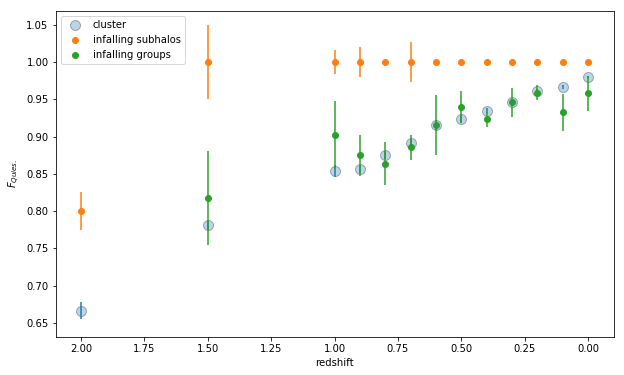

In [17]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.scatter(zs_full, fq_cluster_snaps_med, label = 'cluster', s = 100, edgecolor = 'black', alpha = .3)
ax.errorbar(zs_full, fq_cluster_snaps_med, yerr = fq_cluster_snaps_std, linestyle = '')

ax.scatter(zs_full, fq_infall_sub_snaps_med, label = 'infalling subhalos')
ax.errorbar(zs_full, fq_infall_sub_snaps_med, yerr = fq_infall_sub_snaps_std, linestyle = '')


ax.scatter(zs_full, fq_infall_grp_snaps_med, label = 'infalling groups')
ax.errorbar(zs_full, fq_infall_grp_snaps_med, yerr = fq_infall_grp_snaps_std, linestyle = '')

ax.legend()

ax.set_xlim(2.1, -0.1)
ax.set_xlabel('redshift')
ax.set_ylabel(r'$F_{Quies.}$')

number wieghted quiescent galaxy fraction

In [18]:
fq_cluster_snaps_med = []
fq_cluster_snaps_std = []

fq_infall_sub_snaps_med = []
fq_infall_sub_snaps_std = []

fq_infall_grp_snaps_med = []
fq_infall_grp_snaps_std = []

fq_infall_total_snaps_med = []
fq_infall_total_snaps_std = []

for isnap, snap in enumerate(snaps_full):
    
    #load data
    with open(f'./acchist/fq_cluster_snap{snap:d}', 'rb') as f:
        fq_cluster = pickle.load(f)
    
    with open(f'./acchist/fq_infall_sub_snap{snap:d}', 'rb') as f:
        fq_infall_sub = pickle.load(f)
        
    with open(f'./acchist/n_infall_sub_snap{snap:d}', 'rb') as f:
        n_infall_sub = pickle.load(f)
    
    with open(f'./acchist/fq_infall_grp_snap{snap:d}', 'rb') as f:
        fq_infall_grp = pickle.load(f)
        
    with open(f'./acchist/n_infall_grp_snap{snap:d}', 'rb') as f:
        n_infall_grp = pickle.load(f)
    
    
    fq_cluster = np.array(fq_cluster)
    fq_infall_sub = np.array(fq_infall_sub)
    n_infall_sub = np.array(n_infall_sub)
    fq_infall_grp = np.array(fq_infall_grp)
    n_infall_grp = np.array(n_infall_grp)
    
    sub_nanmask = ~np.isnan(fq_infall_sub)
    fq_infall_sub = fq_infall_sub[sub_nanmask]
    n_infall_sub = n_infall_sub[sub_nanmask]
    
    grp_nanmask = ~np.isnan(fq_infall_grp)
    fq_infall_grp = fq_infall_grp[grp_nanmask]
    n_infall_grp = n_infall_grp[grp_nanmask]
    
    fq_cl_med = []
    fq_sub_med = []
    fq_grp_med = []
    
    fq_total_med = []
    #bootstrap
    for _ in range(100):
        
        idx_cl = np.random.choice(range(len(fq_cluster)), len(fq_cluster), replace = True)
        fq_cl_med.append( np.nanmedian(fq_cluster[idx_cl]) )
        
        idx_sub = np.random.choice(range(len(fq_infall_sub)), size = len(fq_infall_sub), replace = True)
        fq_sub_med.append( np.sum(fq_infall_sub[idx_sub] * n_infall_sub) / np.sum(n_infall_sub) )
        
        idx_grp = np.random.choice(range(len(fq_infall_grp)), size = len(fq_infall_grp), replace = True)
        fq_grp_med.append( np.sum(fq_infall_grp[idx_grp] * n_infall_grp) / np.sum(n_infall_grp) )
        
        fq_total_med.append( (np.sum(fq_infall_grp[idx_grp] * n_infall_grp) + np.sum(fq_infall_sub[idx_sub] * n_infall_sub) ) / (np.sum(n_infall_grp) + np.sum(n_infall_sub)) )
        
    fq_cluster_snaps_med.append(np.median(fq_cl_med))
    fq_cluster_snaps_std.append(np.std(fq_cl_med))
    
    fq_infall_sub_snaps_med.append(np.median(fq_sub_med))
    fq_infall_sub_snaps_std.append(np.std(fq_sub_med))
    
    fq_infall_grp_snaps_med.append(np.median(fq_grp_med))
    fq_infall_grp_snaps_std.append(np.std(fq_grp_med))
    
    fq_infall_total_snaps_med.append(np.median(fq_total_med))
    fq_infall_total_snaps_std.append(np.std(fq_total_med))

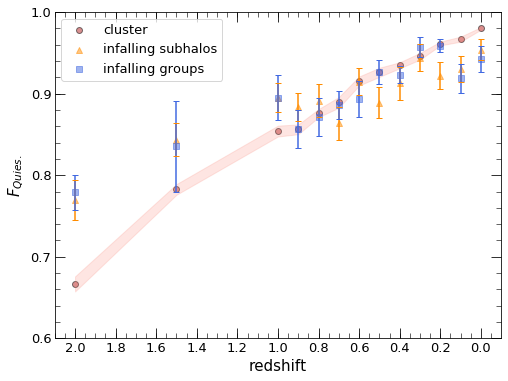

In [33]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.scatter(zs_full, fq_cluster_snaps_med, label = 'cluster', edgecolor = 'black', alpha = .5, color = 'firebrick')
ax.fill_between(zs_full, np.array(fq_cluster_snaps_med) + np.array(fq_cluster_snaps_std),  np.array(fq_cluster_snaps_med) - np.array(fq_cluster_snaps_std), alpha = .2, color = 'salmon')
# ax.errorbar(zs_full, fq_cluster_snaps_med, yerr = fq_cluster_snaps_std)

ax.scatter(zs_full, fq_infall_sub_snaps_med, label = 'infalling subhalos', marker = '^', alpha = .5, color = 'darkorange')
ax.errorbar(zs_full, fq_infall_sub_snaps_med, yerr = fq_infall_sub_snaps_std, linestyle = '', color = 'darkorange', capsize = 3)


ax.scatter(zs_full, fq_infall_grp_snaps_med, label = 'infalling groups', marker = 's', alpha = .5, color = 'royalblue')
ax.errorbar(zs_full, fq_infall_grp_snaps_med, yerr = fq_infall_grp_snaps_std, linestyle = '', color = 'royalblue', capsize = 3)


# ax.scatter(zs_full, fq_infall_total_snaps_med, label = 'infalling subs + grps', marker = 'x')
# ax.errorbar(zs_full, fq_infall_total_snaps_med, yerr = fq_infall_total_snaps_std, linestyle = '')

ax.legend(fontsize = 13)

ax.set_xlim(2.1, -0.1)
ax.set_ylim(0.6, 1)

ax.set_xlabel('redshift', fontsize = 15)
ax.set_ylabel(r'$F_{Quies.}$', fontsize = 15)

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which = 'major', length = 10, direction = 'in', labelsize = 13)
ax.tick_params(which = 'minor', length = 5, direction = 'in', labelsize = 13)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

fig.savefig('./figs/infalling_comparison.png')

connected(high FoF) vs. isolated(low FoF)

In [149]:
fq_cluster_snaps_med_con = []
fq_cluster_snaps_std_con = []

fq_infall_sub_snaps_med_con = []
fq_infall_sub_snaps_std_con = []

fq_infall_grp_snaps_med_con = []
fq_infall_grp_snaps_std_con = []

fq_infall_total_snaps_med_con = []
fq_infall_total_snaps_std_con = []

fq_cluster_snaps_med_iso = []
fq_cluster_snaps_std_iso = []

fq_infall_sub_snaps_med_iso = []
fq_infall_sub_snaps_std_iso = []

fq_infall_grp_snaps_med_iso = []
fq_infall_grp_snaps_std_iso = []

fq_infall_total_snaps_med_iso = []
fq_infall_total_snaps_std_iso = []

for isnap, snap in enumerate(snaps_full):
    
    #load data
    with open(f'./acchist/fof_cluster_snap{snap:d}', 'rb') as f:
        fof_cluster = pickle.load(f)
    
    with open(f'./acchist/fq_cluster_snap{snap:d}', 'rb') as f:
        fq_cluster = pickle.load(f)
    
    with open(f'./acchist/fq_infall_sub_snap{snap:d}', 'rb') as f:
        fq_infall_sub = pickle.load(f)
        
    with open(f'./acchist/n_infall_sub_snap{snap:d}', 'rb') as f:
        n_infall_sub = pickle.load(f)
    
    with open(f'./acchist/fq_infall_grp_snap{snap:d}', 'rb') as f:
        fq_infall_grp = pickle.load(f)
        
    with open(f'./acchist/n_infall_grp_snap{snap:d}', 'rb') as f:
        n_infall_grp = pickle.load(f)
    
    fof_cluster = np.array(fof_cluster)
    fq_cluster = np.array(fq_cluster)
    fq_infall_sub = np.array(fq_infall_sub)
    n_infall_sub = np.array(n_infall_sub)
    fq_infall_grp = np.array(fq_infall_grp)
    n_infall_grp = np.array(n_infall_grp)
    
    con_mask = ( fof_cluster >= np.nanmedian(fof_cluster) )
    iso_mask = ( fof_cluster < np.nanmedian(fof_cluster) )
    
    ############# connected case
    fq_cluster_masked = fq_cluster[con_mask]
    
    sub_nanmask = ~np.isnan(fq_infall_sub)
    fq_infall_sub_masked = fq_infall_sub[sub_nanmask & con_mask]
    n_infall_sub_masked = n_infall_sub[sub_nanmask & con_mask]
    
    grp_nanmask = ~np.isnan(fq_infall_grp)
    fq_infall_grp_masked = fq_infall_grp[grp_nanmask & con_mask]
    n_infall_grp_masked = n_infall_grp[grp_nanmask & con_mask]
    
    fq_cl_med_con = []
    fq_sub_med_con = []
    fq_grp_med_con = []
    #bootstrap
    for _ in range(100):
        
        idx_cl = np.random.choice(range(len(fq_cluster_masked)), len(fq_cluster_masked), replace = True)
        fq_cl_med_con.append( np.nanmedian(fq_cluster_masked[idx_cl]) )
        
        idx_sub = np.random.choice(range(len(fq_infall_sub_masked)), size = len(fq_infall_sub_masked), replace = True)
        fq_sub_med_con.append( np.sum(fq_infall_sub_masked[idx_sub] * n_infall_sub_masked) / np.sum(n_infall_sub_masked) )
        
        idx_grp = np.random.choice(range(len(fq_infall_grp_masked)), size = len(fq_infall_grp_masked), replace = True)
        fq_grp_med_con.append( np.sum(fq_infall_grp_masked[idx_grp] * n_infall_grp_masked) / np.sum(n_infall_grp_masked) )
        
    fq_cluster_snaps_med_con.append(np.median(fq_cl_med_con))
    fq_cluster_snaps_std_con.append(np.std(fq_cl_med_con))
    
    fq_infall_sub_snaps_med_con.append(np.median(fq_sub_med_con))
    fq_infall_sub_snaps_std_con.append(np.std(fq_sub_med_con))
    
    fq_infall_grp_snaps_med_con.append(np.median(fq_grp_med_con))
    fq_infall_grp_snaps_std_con.append(np.std(fq_grp_med_con))
    
    ############# isolated case
    fq_cluster_masked = fq_cluster[iso_mask]
    
    sub_nanmask = ~np.isnan(fq_infall_sub)
    fq_infall_sub = fq_infall_sub[sub_nanmask & iso_mask]
    n_infall_sub = n_infall_sub[sub_nanmask & iso_mask]
    
    grp_nanmask = ~np.isnan(fq_infall_grp)
    fq_infall_grp = fq_infall_grp[grp_nanmask & iso_mask]
    n_infall_grp = n_infall_grp[grp_nanmask & iso_mask]
    
    fq_cl_med_iso = []
    fq_sub_med_iso = []
    fq_grp_med_iso = []
    
    #bootstrap
    for _ in range(100):
        
        idx_cl = np.random.choice(range(len(fq_cluster_masked)), len(fq_cluster_masked), replace = True)
        fq_cl_med_iso.append( np.nanmedian(fq_cluster_masked[idx_cl]) )
        
        idx_sub = np.random.choice(range(len(fq_infall_sub_masked)), size = len(fq_infall_sub_masked), replace = True)
        fq_sub_med_iso.append( np.sum(fq_infall_sub_masked[idx_sub] * n_infall_sub_masked) / np.sum(n_infall_sub_masked) )
        
        idx_grp = np.random.choice(range(len(fq_infall_grp_masked)), size = len(fq_infall_grp_masked), replace = True)
        fq_grp_med_iso.append( np.sum(fq_infall_grp_masked[idx_grp] * n_infall_grp_masked) / np.sum(n_infall_grp_masked) )
        
    fq_cluster_snaps_med_iso.append(np.median(fq_cl_med_iso))
    fq_cluster_snaps_std_iso.append(np.std(fq_cl_med_iso))
    
    fq_infall_sub_snaps_med_iso.append(np.median(fq_sub_med_iso))
    fq_infall_sub_snaps_std_iso.append(np.std(fq_sub_med_iso))
    
    fq_infall_grp_snaps_med_iso.append(np.median(fq_grp_med_iso))
    fq_infall_grp_snaps_std_iso.append(np.std(fq_grp_med_iso))

In [148]:
# # fq_cluster_snaps_med_con
# # fq_infall_sub_snaps_med_con
# # fq_sub_med_con

# fq_infall_sub
# n_infall_sub_masked

Text(0.5,1,'connected')

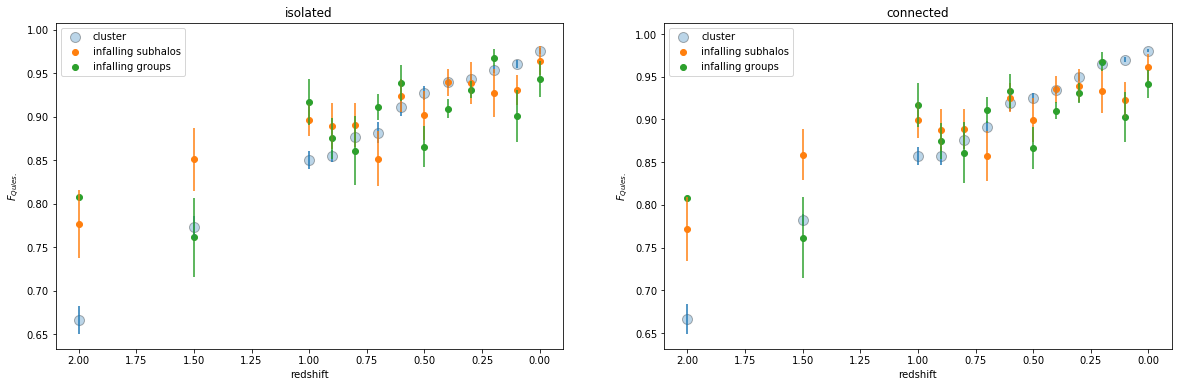

In [150]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
########### isolated
ax[0].scatter(zs_full, fq_cluster_snaps_med_iso, label = 'cluster', s = 100, edgecolor = 'black', alpha = .3)
ax[0].errorbar(zs_full, fq_cluster_snaps_med_iso, yerr = fq_cluster_snaps_std_iso, linestyle = '')

ax[0].scatter(zs_full, fq_infall_sub_snaps_med_iso, label = 'infalling subhalos')
ax[0].errorbar(zs_full, fq_infall_sub_snaps_med_iso, yerr = fq_infall_sub_snaps_std_iso, linestyle = '')

ax[0].scatter(zs_full, fq_infall_grp_snaps_med_iso, label = 'infalling groups')
ax[0].errorbar(zs_full, fq_infall_grp_snaps_med_iso, yerr = fq_infall_grp_snaps_std_iso, linestyle = '')

ax[0].legend()

ax[0].set_xlim(2.1, -0.1)
ax[0].set_xlabel('redshift')
ax[0].set_ylabel(r'$F_{Quies.}$')

ax[0].set_title('isolated')

########### connected
ax[1].scatter(zs_full, fq_cluster_snaps_med_con, label = 'cluster', s = 100, edgecolor = 'black', alpha = .3)
ax[1].errorbar(zs_full, fq_cluster_snaps_med_con, yerr = fq_cluster_snaps_std_con, linestyle = '')

ax[1].scatter(zs_full, fq_infall_sub_snaps_med_con, label = 'infalling subhalos')
ax[1].errorbar(zs_full, fq_infall_sub_snaps_med_con, yerr = fq_infall_sub_snaps_std_con, linestyle = '')

ax[1].scatter(zs_full, fq_infall_grp_snaps_med_con, label = 'infalling groups')
ax[1].errorbar(zs_full, fq_infall_grp_snaps_med_con, yerr = fq_infall_grp_snaps_std_con, linestyle = '')

ax[1].legend()

ax[1].set_xlim(2.1, -0.1)
ax[1].set_xlabel('redshift')
ax[1].set_ylabel(r'$F_{Quies.}$')

ax[1].set_title('connected')


# Calcualte how probable the accreting galaxies/groups are residing in the FoF overdense region

In [22]:
snaps_full

array([99, 91, 84, 78, 72, 67, 63, 59, 56, 53, 50, 40, 33])

In [19]:
fofs_snaps = []

for snap in snaps_full:
    
    print(snap)
    
    # load subhalo at given snap
    subhalos_curr = h5py.File(f'./subhalos/subs_{snap:d}.hdf5', 'r')
    
    gal_mask = subhalos_curr['SubhaloMassType'][:, 4] * 1e10 / 0.704 >= 10**9.5
    z = zs_full[snaps_full == 99][0]

    #grid at certain snap
    bins = np.arange(0 , 205000, 500)
    coords = np.array(list(zip(subhalos_curr['SubhaloPos'][:, 0][gal_mask], subhalos_curr['SubhaloPos'][:, 1][gal_mask], subhalos_curr['SubhaloPos'][:, 2][gal_mask])))

    grid, (xedges, yedges, zedges) = np.histogramdd(coords, bins = (bins, bins, bins))
    mean, std = np.mean(grid), np.std(grid)

    filtered = uniform_filter(grid, 3, mode = 'wrap')
    mean2, std2 = np.mean(filtered), np.std(filtered)
    
    fofgrid = (grid >= mean2 + std2 * 2)
    
    fofs_snaps.append(fofgrid)

99
91
84
78
72
67
63
59
56
53
50
40
33


In [20]:
def cal_fof(start, cands):
    
    check = np.full(len(cands), True, dtype = bool)
    
    f1mask = np.sqrt(np.sum((cands - start)**2, axis = 1)) <= 4
    f1_index = list(np.where(f1mask)[0])
    
    check[f1mask] = False
    
    if len(f1_index) == 0:
        return []
    
    new_index = []
    
    temp_index = []
    
    first = True
    
    while True:
        if first:
            first = False
            cand_index = f1_index.copy()
        else:
            cand_index = temp_index.copy()
            temp_index = []
            
        for j in range(len(cand_index)):
            f2mask = np.sqrt(np.sum((cands - cands[cand_index[j]])**2, axis = 1)) <= 4
            f2_index = np.where(f2mask & check)[0]
            
            check[f2_index] = False
            
            if len(f2_index) == 0:
                continue
            
            temp_index.extend(list(f2_index))
            
        new_index.extend(temp_index)
        
        if len(temp_index) ==0:
            break
    
    f1_index.extend(new_index)
    final_index = f1_index
    
    return final_index

calculate the residence rate

In [ ]:
#start from present epoch

# load subhalo at given snap
subhalos_curr = h5py.File(f'./subhalos/subs_99.hdf5', 'r')
z = zs_full[snaps_full == 99][0]

# # galaxy mask
gal_mask = subhalos_curr['SubhaloMassType'][:, 4] * 1e10 / 0.704 >= 10**9.5

# isin_total = []

# investigate the individual galaxy cluster candidates at given snapshot
for c in range(len(trees)):

    t = trees[c]

    curr_mask = t['SnapNum'] == 99

    if sum(curr_mask) == 0:
        continue

    # current member
    grnr_snap = t['SubhaloGrNr'][curr_mask][0]

    mem_mask = subhalos_curr['SubhaloGrNr'][:] == grnr_snap
    ids_currmem = np.where(mem_mask & gal_mask)[0]

    # calculate FoF
    with h5py.File(f'./groups/grp_snap99.hdf5', 'r') as f:
        center_pos = f['GroupPos'][:][grnr_snap]

    if (center_pos[0] <= 10000) | (center_pos[0] >= (205000 - 10000)) | (center_pos[1] <= 10000 ) | (center_pos[1] >= (205000 - 10000) ) | (center_pos[2] <= 10000 ) | (center_pos[2] >= (205000 - 10000) ):
        continue
    
    grid = fofs_snaps[0]
    
    xidx, yidx, zidx = [int(center_pos[i]/500) for i in range(3)]
    subgrid = grid[xidx-20:xidx+20, yidx-20:yidx+20, zidx-20:zidx+20]

    start = np.array([20, 20, 20])
    cands = np.argwhere(subgrid)

    findex = cal_fof(start, cands)
    
    pos_currmem = subhalos_curr['SubhaloPos'][:][ids_currmem]
    idx_currmem = [[int((x[0] - center_pos[0])/500)+20, int((x[1] - center_pos[1])/500)+20, int((x[2] - center_pos[2])/500)+20] for x in pos_currmem]
    
    bool_isin = [True if x in cands[findex] else False for x in idx_currmem]
    
    isin_cls = []
    isin_cls.append(sum(bool_isin) / len(bool_isin))
    
    ## track member galaxies
    cands_tree = []
    fields = ['SubfindID', 'SnapNum', 'SubhaloGrNr', 'SubhaloPos']
    for idx in ids_currmem:
        try:
            tree = il.sublink.loadTree(basePath, 99, idx, fields=fields, onlyMPB = True)
        except:
            pass

        if tree: #if not none
            cands_tree.append(tree)

    for snap in snaps_full[1:]:
        
        print(snap)
        
        ##### infalling groups and subhalos
        before_mask = t['SnapNum'] == snap

        if sum(before_mask) == 0:
            isin_cls.append(np.nan)
            continue

        # infalling member
        grnr_snap_before = t['SubhaloGrNr'][before_mask][0]

        # find infalling candidates
        
        cands_tree_snap = [x for x in cands_tree if  np.any(x['SnapNum'] == snap) & np.any(x['SnapNum'] == 99)]
        cands_tree_snap = [x for x in cands_tree_snap if (x['SubhaloGrNr'][x['SnapNum'] == 99][0] == grnr_snap) & (x['SubhaloGrNr'][x['SnapNum'] == snap][0] != grnr_snap_before)]
        cands_tree_snap = np.array(cands_tree_snap)

        ids_infallmem = np.array([x['SubfindID'][x['SnapNum'] == snap][0] for x in cands_tree_snap])
        
        with  h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
            gal_mask_snap = f['SubhaloMassType'][:, 4] * 1e10 / 0.704 >= 10**9.5
            gal_snap= np.where(gal_mask_snap)[0]
            
        ids_infallmem = np.intersect1d(gal_snap, ids_infallmem)
        #  [x for x in ids_infallmem if f['SubhaloMassType'][:, 4][x] * 1e10 / 0.704 >= 10**8.5]

        # when there is no infalling group/subhalo 
        if len(ids_infallmem) == 0:
            isin_cls.append(np.nan)
            continue
        
        # calculate FOF inclusion ratio
        idx_snap = np.where(snaps_full == snap)[0][0]
        
        grid = fofs_snaps[idx_snap]
    
        with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
            center_pos = f['GroupPos'][:][grnr_snap_before]
        
        xidx, yidx, zidx = [int(center_pos[i]/500) for i in range(3)]
        subgrid = grid[xidx-20:xidx+20, yidx-20:yidx+20, zidx-20:zidx+20]

        start = np.array([20, 20, 20])
        cands = np.argwhere(subgrid)

        findex = cal_fof(start, cands)
        
        with  h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
            pos_infallmem = f['SubhaloPos'][:][ids_infallmem]
        
        idx_infallmem = [[int((x[0] - center_pos[0])/500)+20, int((x[1] - center_pos[1])/500)+20, int((x[2] - center_pos[2])/500)+20] for x in pos_infallmem]
        
        bool_isin = [True if x in cands[findex] else False for x in idx_infallmem]
        isin_cls.append(sum(bool_isin) / len(bool_isin))
    
    print(isin_cls)
    
    with open(f'./path_prob_corr_sm9p5/cands{c:d}', 'wb') as f:
        pickle.dump(isin_cls, f)

Warning, empty return. Subhalo [802] at snapNum [99] not in tree.
Warning, empty return. Subhalo [832] at snapNum [99] not in tree.
Warning, empty return. Subhalo [834] at snapNum [99] not in tree.
Warning, empty return. Subhalo [890] at snapNum [99] not in tree.
Warning, empty return. Subhalo [997] at snapNum [99] not in tree.
91
84
78
72
67
63
59
56
53
50
40
33
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Warning, empty return. Subhalo [12144] at snapNum [99] not in tree.
Warning, empty return. Subhalo [12181] at snapNum [99] not in tree.
Warning, empty return. Subhalo [12183] at snapNum [99] not in tree.
Warning, empty return. Subhalo [12212] at snapNum [99] not in tree.
Warning, empty return. Subhalo [12336] at snapNum [99] not in tree.
Warning, empty return. Subhalo [12357] at snapNum [99] not in tree.
91
84
78
72
67
63
59
56
53
50
40
33
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Warning, empty return. Subhalo [23035] at snapNum [99] not

residence rate as a function of redshift

In [28]:
prob_list = os.listdir('./path_prob')
prob_list = [x for x in prob_list if 'cands' in x]

probs = []

for prob in prob_list:
    
    with open(f'./path_prob/' + prob, 'rb') as f:
        temp = pickle.load(f)
    
    probs.append(temp)
    
probs = np.array(probs)

In [29]:
# np.samp

In [30]:
final_probs_mean = []
final_probs_std = []

for i in range(len(snaps_full[1:])):
    
    samp = probs[:, i]
    
    meds = []
    
    for _ in range(1000):
        
        boot = np.random.choice(samp, size = len(samp), replace = True)
        meds.append(np.nanmean(boot))
        
    final_probs_mean.append(np.mean(meds))
    final_probs_std.append(np.std(meds))

In [31]:
final_probs_mean

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.995183574879227,
 0.9901025132276745,
 0.9904233754185686,
 0.9952125603864733]

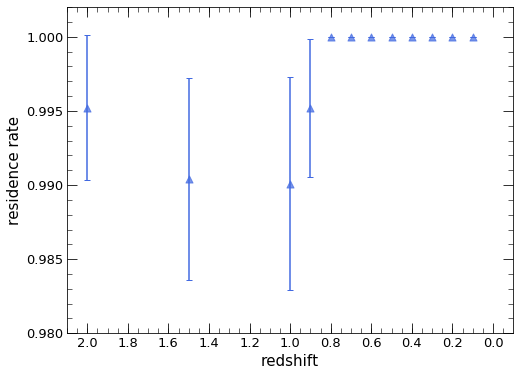

In [41]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.scatter(zs_full[1:], final_probs_mean, color = 'royalblue', marker = '^', alpha = .7, s = 50)
ax.errorbar(zs_full[1:], final_probs_mean, yerr = final_probs_std, linestyle = '', color = 'royalblue', capsize = 3)

ax.set_xlim(2.1, -0.1)
ax.set_ylim(0.980, 1.002)

ax.set_xlabel('redshift', fontsize = 15)
ax.set_ylabel('residence rate', fontsize = 15)

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.005))

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which = 'major', length = 10, direction = 'in', labelsize = 13)
ax.tick_params(which = 'minor', length = 5, direction = 'in', labelsize = 13)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

fig.savefig('./figs/residence_rate.png')

In [41]:
snaps_full[1:]

array([91, 84, 78, 72, 67, 63, 59, 56, 53, 50, 40, 33])

# time evolution density field figures (2D)

Warning, empty return. Subhalo [802] at snapNum [99] not in tree.
Warning, empty return. Subhalo [832] at snapNum [99] not in tree.
Warning, empty return. Subhalo [834] at snapNum [99] not in tree.
Warning, empty return. Subhalo [890] at snapNum [99] not in tree.
Warning, empty return. Subhalo [997] at snapNum [99] not in tree.
Warning, empty return. Subhalo [1205] at snapNum [99] not in tree.
Warning, empty return. Subhalo [1336] at snapNum [99] not in tree.
Warning, empty return. Subhalo [1338] at snapNum [99] not in tree.
Warning, empty return. Subhalo [1352] at snapNum [99] not in tree.
Warning, empty return. Subhalo [1402] at snapNum [99] not in tree.
Warning, empty return. Subhalo [1446] at snapNum [99] not in tree.
Warning, empty return. Subhalo [1564] at snapNum [99] not in tree.
Warning, empty return. Subhalo [1720] at snapNum [99] not in tree.
Warning, empty return. Subhalo [1721] at snapNum [99] not in tree.
Warning, empty return. Subhalo [1756] at snapNum [99] not in tree.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in true_divide


84
78
72
67
63
59
56
53
50
40
33


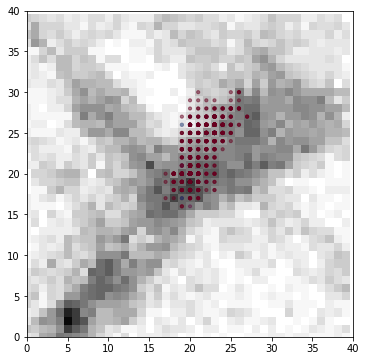

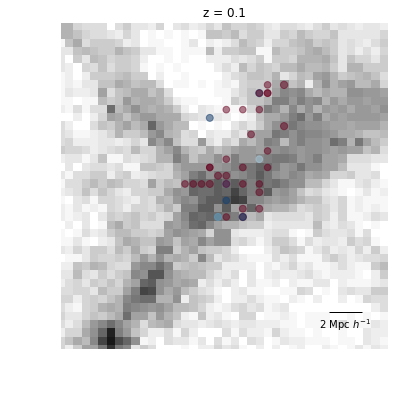

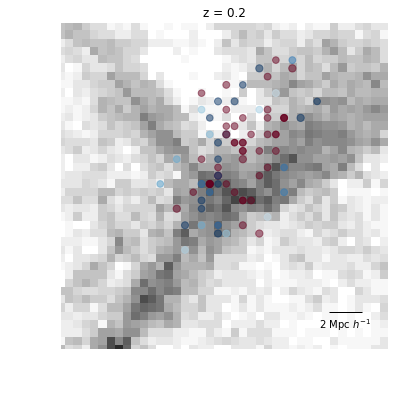

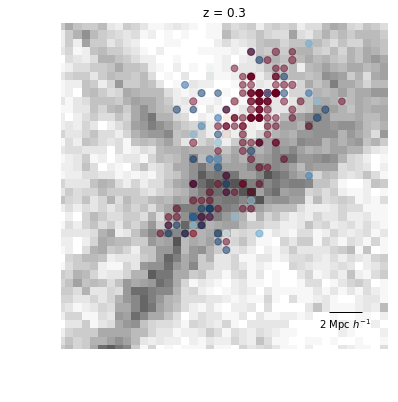

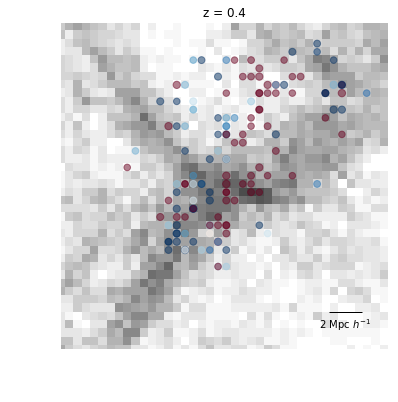

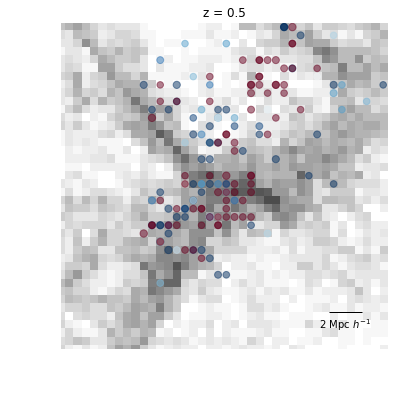

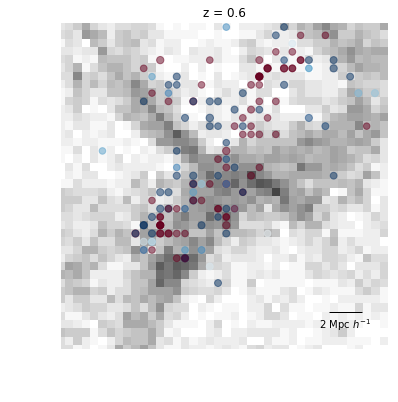

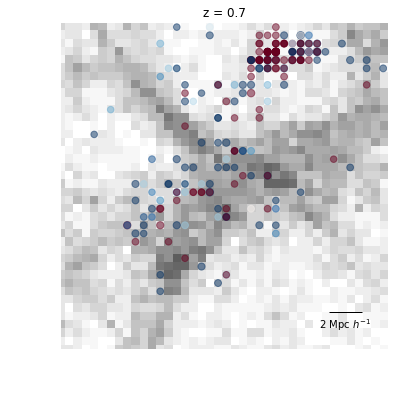

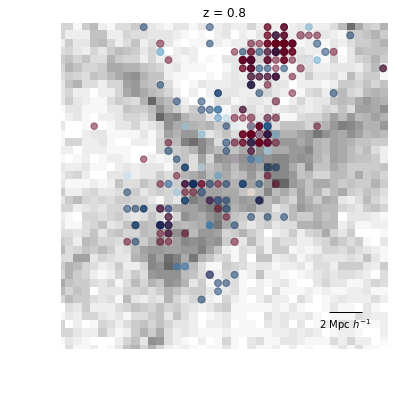

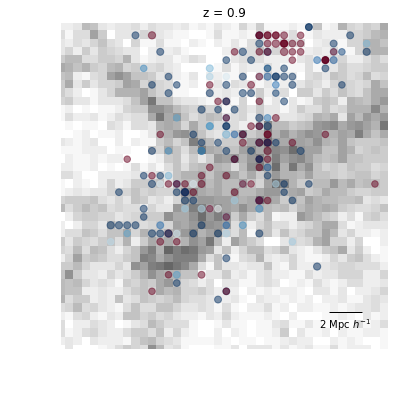

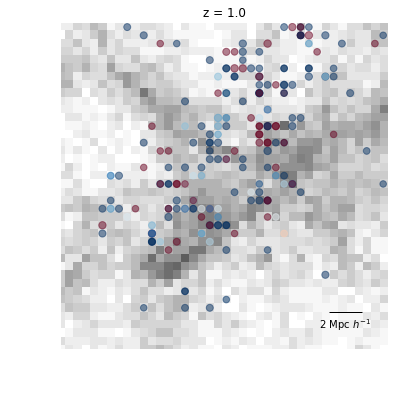

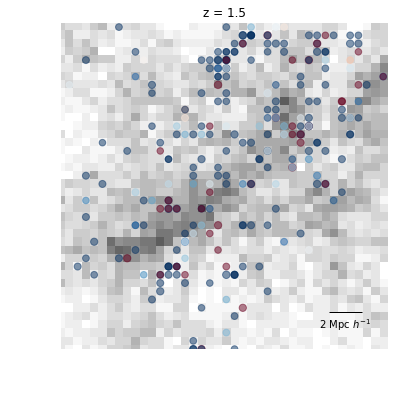

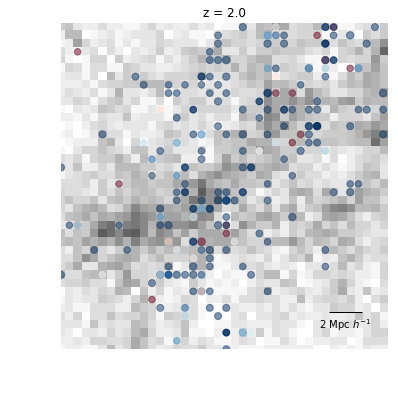

In [26]:
#start from present epoch

# load subhalo at given snap
subhalos_curr = h5py.File(f'./subhalos/subs_99.hdf5', 'r')
z = zs_full[snaps_full == 99][0]

# # galaxy mask
gal_mask = subhalos_curr['SubhaloMassType'][:, 4] * 1e10 / 0.704 >= 10**8.5

# isin_total = []

# investigate the individual galaxy cluster candidates at given snapshot
# for c in range(len(trees)):
for c in range(1):

    t = trees[c]

    curr_mask = t['SnapNum'] == 99

    if sum(curr_mask) == 0:
        continue

    # current member
    grnr_snap = t['SubhaloGrNr'][curr_mask][0]

    mem_mask = subhalos_curr['SubhaloGrNr'][:] == grnr_snap
    ids_currmem = np.where(mem_mask & gal_mask)[0]

    # calculate FoF
    with h5py.File(f'./groups/grp_snap99.hdf5', 'r') as f:
        center_pos = f['GroupPos'][:][grnr_snap]

    if (center_pos[0] <= 10000) | (center_pos[0] >= (205000 - 10000)) | (center_pos[1] <= 10000 ) | (center_pos[1] >= (205000 - 10000) ) | (center_pos[2] <= 10000 ) | (center_pos[2] >= (205000 - 10000) ):
        continue
    
    grid = fofs_snaps[0]
    
    xidx, yidx, zidx = [int(center_pos[i]/500) for i in range(3)]
    subgrid = grid[xidx-20:xidx+20, yidx-20:yidx+20, zidx-20:zidx+20]

    start = np.array([20, 20, 20])
    cands = np.argwhere(subgrid)

    findex = cal_fof(start, cands)
    
    pos_currmem = subhalos_curr['SubhaloPos'][:][ids_currmem]
    idx_currmem = [[int((x[0] - center_pos[0])/500)+20, int((x[1] - center_pos[1])/500)+20, int((x[2] - center_pos[2])/500)+20] for x in pos_currmem]
    idx_currmem = np.array(idx_currmem) 
    
    # colors as an indicator of sSFR
    sfr_mask = np.isin(SFRs[f'Snapshot_99']['SubfindID'][:], ids_currmem) # SFR file
    ssfrs = SFRs[f'Snapshot_99']['SFR_MsunPerYrs_in_InRad_100Myrs'][sfr_mask] / (subhalos_curr['SubhaloMassType'][:, 4][ids_currmem] * 1e10 / 0.704)

    grid_bool = np.full(subgrid.shape, 0)
    grid_bool[cands[findex][:, 0], cands[findex][:, 1], cands[findex][:, 2]] = 1
    
    fig, ax = plt.subplots(figsize = (6, 6))
    ax.imshow(np.sum(grid_bool, axis = 2), cmap = 'gray_r', vmin = 0, vmax = 30)
    ax.scatter(idx_currmem[:, 0], idx_currmem[:, 1],  c = np.log10(ssfrs+1e-15), vmin = -13, vmax = -9, cmap = 'RdBu', alpha = .5, s = 10)
    ax.set_xlim(0, 40)
    ax.set_ylim(0, 40)
    
    
    ## track member galaxies
    cands_tree = []
    fields = ['SubfindID', 'SnapNum', 'SubhaloGrNr', 'SubhaloPos']
    for idx in ids_currmem:
        try:
            tree = il.sublink.loadTree(basePath, 99, idx, fields=fields, onlyMPB = True)
        except:
            pass

        if tree: #if not none
            cands_tree.append(tree)

    for snap in snaps_full[1:]:
        
        print(snap)
        
        ##### infalling groups and subhalos
        before_mask = t['SnapNum'] == snap

        if sum(before_mask) == 0:
            isin_cls.append(np.nan)
            continue

        # infalling member
        grnr_snap_before = t['SubhaloGrNr'][before_mask][0]

        # find infalling candidates
        
        cands_tree_snap = [x for x in cands_tree if  np.any(x['SnapNum'] == snap) & np.any(x['SnapNum'] == 99)]
        cands_tree_snap = [x for x in cands_tree_snap if (x['SubhaloGrNr'][x['SnapNum'] == 99][0] == grnr_snap) & (x['SubhaloGrNr'][x['SnapNum'] == snap][0] != grnr_snap_before)]
        cands_tree_snap = np.array(cands_tree_snap)

        ids_infallmem = np.array([x['SubfindID'][x['SnapNum'] == snap][0] for x in cands_tree_snap])
        
        with  h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
            gal_mask_snap = f['SubhaloMassType'][:, 4] * 1e10 / 0.704 >= 10**8.5
            gal_snap= np.where(gal_mask_snap)[0]
            
        ids_infallmem = np.intersect1d(gal_snap, ids_infallmem)
        #  [x for x in ids_infallmem if f['SubhaloMassType'][:, 4][x] * 1e10 / 0.704 >= 10**8.5]

        # when there is no infalling group/subhalo 
        if len(ids_infallmem) == 0:
            isin_cls.append(np.nan)
            continue
        
        # calculate FOF inclusion ratio
        idx_snap = np.where(snaps_full == snap)[0][0]
        
        grid = fofs_snaps[idx_snap]
    
        with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
            center_pos = f['GroupPos'][:][grnr_snap_before]
        
        xidx, yidx, zidx = [int(center_pos[i]/500) for i in range(3)]
        subgrid = grid[xidx-20:xidx+20, yidx-20:yidx+20, zidx-20:zidx+20]

        start = np.array([20, 20, 20])
        cands = np.argwhere(subgrid)

        findex = cal_fof(start, cands)
        
        with  h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
            pos_infallmem = f['SubhaloPos'][:][ids_infallmem]
            mass_infallmem = f['SubhaloMassType'][:, 4][ids_infallmem] * 1e10 / 0.704
        
        idx_infallmem = [[int((x[0] - center_pos[0])/500)+20, int((x[1] - center_pos[1])/500)+20, int((x[2] - center_pos[2])/500)+20] for x in pos_infallmem]
        idx_infallmem = np.array(idx_infallmem) 

        # colors as an indicator of sSFR
        sfr_mask = np.isin(SFRs[f'Snapshot_{snap}']['SubfindID'][:], ids_infallmem) # SFR file
        ssfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_100Myrs'][sfr_mask] / (subhalos_curr['SubhaloMassType'][:, 4][ids_infallmem] * 1e10 / 0.704)
        
        grid_bool = np.full(subgrid.shape, 0)
        grid_bool[cands[findex][:, 0], cands[findex][:, 1], cands[findex][:, 2]] = 1
        
        fig, ax = plt.subplots(figsize = (6, 6))
        ax.imshow(np.sum(subgrid, axis = 2), cmap = 'gray_r', vmin = 0, vmax = 30)
        ax.scatter(idx_infallmem[:, 0], idx_infallmem[:, 1], c = np.log10(ssfrs+1e-15), vmin = -13, vmax = -9, cmap = 'RdBu', alpha = .5, s = np.log10(mass_infallmem) * 5)
        ax.set_xlim(0, 39.5)
        ax.set_ylim(0, 39.5)
        
        ax.set_axis_off()
        
        ax.set_xlabel(r'$x [h^{-1}Mpc]$', fontsize = 15)
        ax.set_ylabel(r'$y [h^{-1}Mpc]$', fontsize = 15)
        
        ax.set_xticks([10, 20, 30])
        ax.set_yticks([10, 20, 30])
        ax.set_xticklabels(['-10', '0', '10'], fontsize=13)
        ax.set_yticklabels(['-10', '0', '10'], fontsize=13)
        
        scalebar = AnchoredSizeBar(ax.transData, 4, r'2 Mpc $h^{-1}$', 'lower right', frameon = False, pad = 1.5, sep = 5, size_vertical = .005)
        ax.add_artist(scalebar)
        
        z = zs_full[snaps_full == snap][0]

        ax.set_title(f'z = {z:.1f}')
        
        fig.savefig(f'./figs/evolution_z_{z:.1f}.png')
#     with open(f'./path_prob/cands{c:d}', 'wb') as f:
#         pickle.dump(isin_cls, f)

mass 로 size weight 주기

In [ ]:
plt.imshow(subgrid)

In [26]:
subgrid.shape

(40, 40, 40)

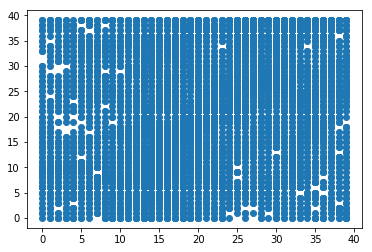

In [36]:
plt.scatter(cands[findex][:, 0], cands[findex][:, 1])

In [94]:
grid_bool = np.full(subgrid.shape, 0)
grid_bool[cands[findex][:, 0], cands[findex][:, 1], cands[findex][:, 2]] = 1

(40, 40, 40)

In [95]:
grid_bool[cands[findex][:, 0], cands[findex][:, 1], cands[findex][:, 2]] = 1

In [96]:
len(np.where(grid_bool > 0)[0])

8179

In [79]:
cands[findex]

array([[17, 18, 19],
       [17, 18, 20],
       [17, 18, 21],
       ...,
       [30,  1,  5],
       [34,  1,  0],
       [35,  0,  1]])

In [75]:
cands[findex].shape, 40**3

((8179, 3), 64000)

In [48]:
np.max(np.sum(grid_bool, axis = 2)), np.min(np.sum(grid_bool, axis = 2))

(40, 40)

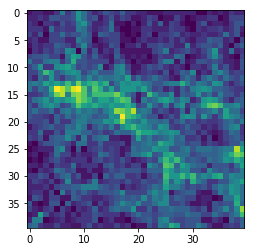

In [97]:
plt.imshow( np.sum(grid_bool, axis = 2) )